In [1]:
import numpy as np
import os
import pyloudnorm as pyln
from openai import OpenAI
import librosa
import soundfile as sf

import pyloudnorm as pyln

import pyfar as pf
import pandas as pd


import sys, random  
sys.path.insert(0, '../')
import utils
from utils.audio_generation import sample, get_model
from utils.audio_processing import compress_spectrogram_simple, compress_spectrogram_with_centroid, equalize_audio, butter_bandpass_filter, pitch_shift_centroid, equalize_audio

from IPython.display import Audio, display
from ipywidgets import widgets

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
#Audio params
loudness_dbfs = -20.0
sample_rate = 16000
stft_channels = 1024
hop_length = 128

# Diffusion params
guidance_scale = 3
n_candidates = 1
batch_size = 1
ddim_steps = 100

In [5]:
loudness_meter = pyln.Meter(sample_rate)

In [9]:
df = pd.read_csv('smooth_rollAvg6_freq-response-DRAKE-BLACK-RAW-0.75-1722943603.275152.csv')
print("Black", np.min(df['smoothed_accVals']), np.max(df['smoothed_accVals']))

df = pd.read_csv('smooth_rollAvg6_freq-response-DRAKE-YELLOW-RAW-0.75-1722942712.900473.csv')
print("Yellow", np.min(df['smoothed_accVals']), np.max(df['smoothed_accVals']))

df = pd.read_csv('smooth_rollAvg6_freq-response-DRAKE-RED-RAW-0.75-1722937125.680299.csv')
print("Red", np.min(df['smoothed_accVals']), np.max(df['smoothed_accVals']))

df = pd.read_csv('smooth_rollAvg6_freq-response-DRAKE-WHITE-RAW-0.75-1722941149.946043.csv')
print("White", np.min(df['smoothed_accVals']), np.max(df['smoothed_accVals']))

Black 39.80307667747323 10689.72280142697
Yellow 201.45715768799104 3814.822506500804
Red 540.1191304347826 1840.147317115252
White 431.5639505422114 816.6032182729551


In [13]:
#https://math.stackexchange.com/questions/970094/convert-a-linear-scale-to-a-logarithmic-scale

def convert_to_log(n, min, max, b=10):
    k = b/(np.log10(max+b) - np.log10(min+b))
    c = -1 * np.log10(min+b) * k

    return k*np.log10(b+n)+c

def renormalize_to_log(n,range1, range2):
    min1, max1 = range1
    min2, max2 = range2

    k = (max2-min2)/(np.log10(10+max1)-np.log10(10+min1))
    c = min2 - k*np.log10(10+min1)

    return k*np.log10(10+n) + c

def renormalize(n, range1, range2):
    delta1 = range1[1] - range1[0]
    delta2 = range2[1] - range2[0]
    return (delta2 * (n - range1[0]) / delta1) + range2[0]  

In [50]:
black_df = pd.read_csv('smooth_rollAvg6_freq-response-DRAKE-BLACK-RAW-0.75-1722943603.275152.csv')
yellow_df = pd.read_csv('smooth_rollAvg6_freq-response-DRAKE-YELLOW-RAW-0.75-1722942712.900473.csv')
red_df = pd.read_csv('smooth_rollAvg6_freq-response-DRAKE-RED-RAW-0.75-1722937125.680299.csv')
white_df = pd.read_csv('smooth_rollAvg6_freq-response-DRAKE-WHITE-RAW-0.75-1722941149.946043.csv')

# df['smoothed_accVal'] = df['accVal'].rolling(10, center=True).mean()

maxval = np.max(black_df['smoothed_accVals'])
minval = np.min(black_df['smoothed_accVals'])

black_new_vals_linear = []
yellow_new_vals_linear = []
red_new_vals_linear = []
white_new_vals_linear = []

maxval = np.max(black_df['smoothed_accVals'])
minval = np.min(black_df['smoothed_accVals'])
for i in black_df['smoothed_accVals']:
    black_new_vals_linear.append(-1*renormalize(i, (minval,maxval), (0,1)))

maxval = np.max(yellow_df['smoothed_accVals'])
minval = np.min(yellow_df['smoothed_accVals'])
for i in yellow_df['smoothed_accVals']:
    yellow_new_vals_linear.append(-1*renormalize(i, (minval,maxval), (0,1)))

maxval = np.max(red_df['smoothed_accVals'])
minval = np.min(red_df['smoothed_accVals'])
for i in red_df['smoothed_accVals']:
    red_new_vals_linear.append(-1*renormalize(i, (minval,maxval), (0,1)))

maxval = np.max(white_df['smoothed_accVals'])
minval = np.min(white_df['smoothed_accVals'])
for i in white_df['smoothed_accVals']:
    white_new_vals_linear.append(-1*renormalize(i, (minval,maxval), (0,1)))

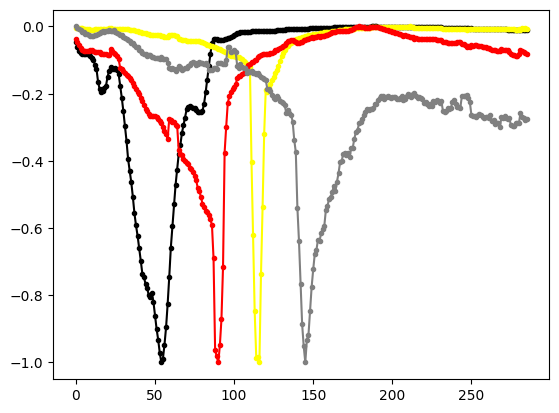

In [51]:
plt.plot(black_new_vals_linear, marker='.', color="black")
plt.plot(yellow_new_vals_linear, marker='.', color="yellow")
plt.plot(red_new_vals_linear, marker='.', color="red")
plt.plot(white_new_vals_linear, marker='.', color="grey")

In [52]:
for type in ["BLACK", "RED", "WHITE", "YELLOW"]:

    os.makedirs('samples_new/imu_tones_equalized/'+type+'/', exist_ok=True)
    for i in range(10,1000,1):
        audio = librosa.tone(i,sr=sample_rate, duration=2)
        audio = equalize_audio(audio, type=type, sample_rate=sample_rate, minval=minval, maxval=maxval)
        
        sf.write('samples_new/imu_tones_equalized/'+type+'/'+str(i)+'.wav', audio, samplerate=sample_rate) #Uncomment to write
    # utils.plot_single(audio, '100')

In [53]:
minval, maxval

(431.5639505422114, 816.6032182729551)

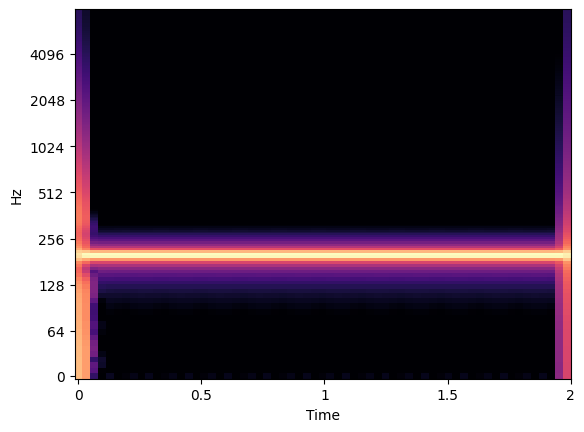

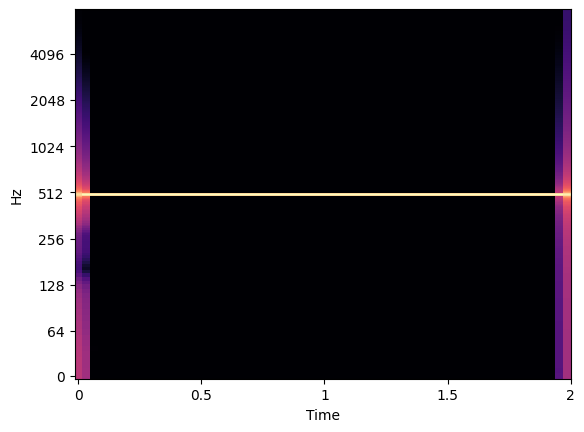

In [63]:
aud,_ = librosa.load("samples_new/imu_tones_equalized/WHITE/200.wav", sr=sample_rate)

utils.plot_single(aud, '')

aud,_ = librosa.load("samples_new/imu_tones_equalized/WHITE/500.wav", sr=sample_rate)

plt.figure()
utils.plot_single(aud, '')

In [17]:
print('Min = ', np.min(df['smoothed_accVals']), '. Converted', convert_to_log(np.min(df['smoothed_accVals']), np.min(df['smoothed_accVals']), np.max(df['smoothed_accVals']), b=10)) 
print('Max = ', np.max(df['smoothed_accVals']), '. Converted', convert_to_log(np.max(df['smoothed_accVals']), np.min(df['smoothed_accVals']), np.max(df['smoothed_accVals']), b=10)) 

min = np.log10(np.min(df['smoothed_accVals']))
max = np.log10(np.max(df['smoothed_accVals']))
print('Min = ', min, '. Converted', renormalize_to_log(min, (min, max), (0,0.5)))
print('Max = ', max, '. Converted', renormalize_to_log(max, (min, max), (0,0.5)))


new_vals = []
for i in df['smoothed_accVals']:
    new_vals.append(-1*renormalize(np.log10(i), (min, max), (0,1)))

Min =  39.80307667747323 . Converted 0.0
Max =  10689.72280142697 . Converted 10.0
Min =  1.5999166432396692 . Converted 0.0
Max =  4.028966443527625 . Converted 0.5


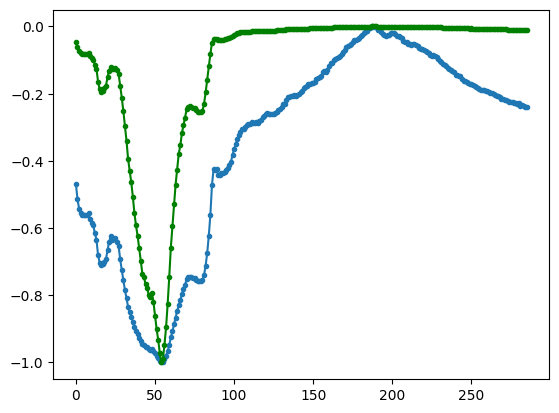

In [18]:
plt.plot(new_vals, marker='.')
plt.plot(new_vals_linear, marker='.', color='green')